## Ejercicio obligatorio
### Advertising

In [55]:
import pandas as pd
import numpy as np

# import file
df = pd.read_csv('../../res/tp4/Advertising.csv', sep=',')  # 200 rows
df = df[['TV', 'Radio', 'Newspaper', 'Sales']]
column_count = len(list(df))

df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [56]:
means = df.mean()
covariance = np.zeros((column_count, column_count))

def calc_sum(col1, col2):
    return sum(map(lambda tupl: (tupl[1][col1] - means[col1]) * (tupl[1][col2] - means[col2]), df.iterrows()))

for i, col1 in enumerate(list(df)):
    for k, col2 in enumerate(list(df)):
        if i > k:
            continue
        s_ik = 1 / column_count * calc_sum(col1, col2)
        covariance[i][k] = covariance[k][i] = s_ik

print(covariance)

[[366704.7571875   3475.659       5269.49275    17431.9121875]
 [  3475.659      10966.2802      5696.2247      2220.6255   ]
 [  5269.49275     5696.2247     23596.8392      1290.58425  ]
 [ 17431.9121875   2220.6255      1290.58425     1354.2871875]]


<AxesSubplot:>

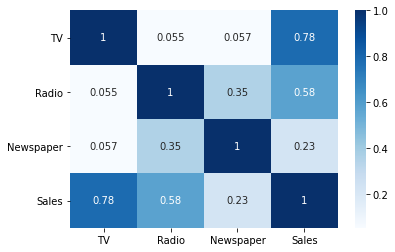

In [57]:
import math
import seaborn as sns

correlation = np.zeros((column_count, column_count))

for i, col1 in enumerate(list(df)):
    for k, col2 in enumerate(list(df)):
        if i > k:
            continue
        s_ik = covariance[i][k]
        s_ii = covariance[i][i]
        s_kk = covariance[k][k]
        correlation[i][k] = correlation[k][i] = s_ik / (math.sqrt(s_ii) * math.sqrt(s_kk))

labels = list(df)
sns.heatmap(correlation, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)

In [58]:
def simple_regression(col_of_interest, other_col):
    """Params:
    col_of_interest: Y
    other_col: X
    """
    num = calc_sum(col_of_interest, other_col)
    denom = calc_sum(other_col, other_col)
    beta_1 = num / denom
    beta_0 = means[col_of_interest] - beta_1 * means[other_col]
    return beta_0, beta_1

Y = 'Sales'
simple_regressions = {}
for col in list(df):
    if col == Y:
        continue
    simple_regressions[col] = simple_regression(Y, col)

print(simple_regressions)

{'TV': (7.032593549127704, 0.04753664043301969), 'Radio': (9.311638095158287, 0.20249578339243954), 'Newspaper': (12.351407069278162, 0.05469309847227332)}


In [63]:

for col, betas in simple_regressions.items():
    error = 0
    x_mean = df[col].mean()
    se_denom = 0
    for index in range(len(df)):
        x = df.iloc[index][col] 
        y = df.iloc[index]['Sales']
        y_est = betas[0] + betas[1] * x
        error += (y - y_est) ** 2
        se_denom += (x - x_mean) ** 2
    sigma_est = math.sqrt(error / (len(df) - 2))
    SE = sigma_est / math.sqrt(se_denom)
    t_stat = betas[1] / SE
    print(f'Error para regresión lineal simple de ({col}, {Y}): {error}')
    print(f'Valor del estadistico t de student: {t_stat}')
    print('\n')
    
print(f'Para TV: el p-value es <.00001, mucho menor a 0.05. Se rechaza H0')
print(f'Para Radio: el p-value es <.00001, mucho menor a 0.05. Se rechaza H0')
print(f'Para Newspaper: el p-value es .000574., menor a 0.05. Se rechaza H0')

Error para regresión lineal simple de (TV, Sales): 2102.5305831313517
Valor del estadistico t de student: 17.667625600875528


Error para regresión lineal simple de (Radio, Sales): 3618.4795490250863
Valor del estadistico t de student: 9.920765472824955


Error para regresión lineal simple de (Newspaper, Sales): 5134.804544111939
Valor del estadistico t de student: 3.2995907436334173


Para TV: el p-value es <.00001, mucho menor a 0.05. Se rechaza H0
Para Radio: el p-value es <.00001, mucho menor a 0.05. Se rechaza H0
Para Newspaper: el p-value es .000574., menor a 0.05. Se rechaza H0


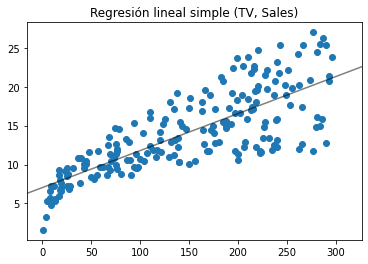

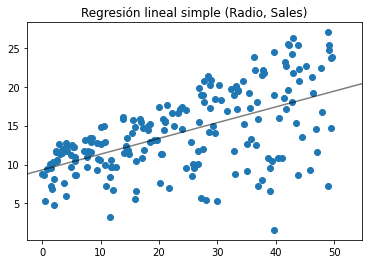

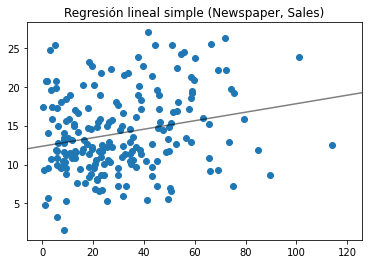

In [60]:
import matplotlib.pyplot as plt

for col, betas in simple_regressions.items():
    fig, ax = plt.subplots()
    ax.scatter(list(df[col]), list(df[Y]))
    yi = betas[0]
    yf = betas[0] + betas[1] * ax.get_xlim()[1]
    plt.axline((0,yi), (ax.get_xlim()[1], yf), color='Black', alpha=0.5)
    plt.title(f'Regresión lineal simple ({col}, {Y})')


In [7]:
X = df[['TV', 'Radio', 'Newspaper']]
X.insert(0, 'X0', 1)
X.head()

,X0,TV,Radio,Newspaper
0,1,230.1,37.8,69.2
1,1,44.5,39.3,45.1
2,1,17.2,45.9,69.3
3,1,151.5,41.3,58.5
4,1,180.8,10.8,58.4


In [8]:
Y = df['Sales']
Y.head()

0    22.1
1    10.4
2     9.3
3    18.5
4    12.9
Name: Sales, dtype: float64

In [47]:
XtX = X.transpose().dot(X)
XtXinv = pd.DataFrame(np.linalg.pinv(XtX.values), columns=XtX.columns, index=XtX.index)
betas = XtXinv.dot(X.transpose()).dot(Y)

print(betas)

X0           2.938889
TV           0.045765
Radio        0.188530
Newspaper   -0.001037
dtype: float64


In [52]:
# Realizar el diagnostico del modelo
RSS = 0
TSS = 0
residuals = []
y_mean = df['Sales'].mean()
for index in range(len(df)):
    y = df.iloc[index]['Sales']
    y_est = X.iloc[index].dot(betas)
    RSS += (y - y_est) ** 2
    TSS += (y - y_mean) ** 2
    residuals.append(y - y_est)
    
F = ((TSS - RSS) / (column_count - 1)) / (RSS / (len(df) - (column_count - 1) - 1))
print(f'TSS para regresion lineal multiple: {TSS}')
print(f'RSS para regresión lineal múltiple: {RSS}')
print(f'Valor del estadistico F: {F}')

TSS para regresion lineal multiple: 5417.148749999997
RSS para regresión lineal múltiple: 556.8252629021873
Valor del estadistico F: 570.2707036590938


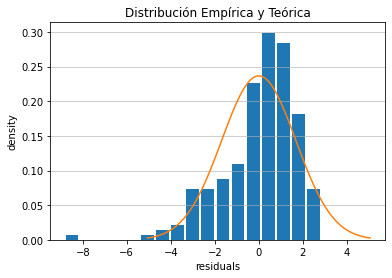

In [49]:
import scipy.stats as stats

sigma_est = math.sqrt(1 / (len(df) - (column_count - 1) - 1 ) * RSS)

plt.hist(residuals, bins='auto', rwidth=0.85, density=True)
plt.grid(axis='y', alpha=0.75)

mu = 0
x = np.linspace(mu - 3 * sigma_est, mu + 3 * sigma_est, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma_est))
plt.xlabel('residuals')
plt.ylabel('density')
# ver si se acota el eje x
plt.title('Distribución Empírica y Teórica')
plt.show()

In [40]:
# Dividir el conjunto en train y test y calcular las metricas de confusion, accuracy, precision y recall
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
